# Eikonal equation on N-dimensional graphs

Given an bounded domain $\Omega \subset \mathbb{R}^d$ ($d\geq 2$) we are interested to solve, 
\begin{align}
|\nabla u(x)| &= f(x) = 0, &&  x \in \Omega\\
u(x) &= 0, && x \in \partial \Omega
\end{align}

## Importing libraries

In [45]:
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy import sparse
from MonotoneScheme import EikonalGraph

# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

## Generating data samples

In [48]:
n = 5000 # number of points
dim = 2 # dimensions

def generate_random_point_cloud_unit_square(n, dim=2, k=20):
    X = np.random.rand(n, dim)
    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W

def generate_random_point_cloud_circle(n, dim=2, k=20):
    X = [[0.5 for _ in range(dim)]]
    count = 1
    R = 0.4
    while count < n:
        z = np.random.rand(dim)
        if  np.sum((z-0.5)**2)  <= R**2:
            X.append(z)
            count += 1
    X = np.array(X)

    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W

def process_sparse_data(X, W):
    #Coordinates of sparse matrix for passing to C code
    I,J,V = sparse.find(W)
    K = np.array((J[1:] - J[:-1]).nonzero()) + 1
    K = np.append(0,np.append(K,len(J)))
    X = np.ascontiguousarray(X, np.float64)
    V = np.ascontiguousarray(V, np.float64)
    K = np.ascontiguousarray(K, np.int32)
    I = np.ascontiguousarray(I, np.int32)
    return X,V,I,K

X, W = generate_random_point_cloud_circle(n,dim,30) # first param: number of points # second param: number of neighbord points
mask    = (np.sum((X-0.5)**2,axis=1) > 0.37**2)
bdy_pts = np.arange(n)[mask]

# X, W = generate_random_point_cloud_unit_square(n,dim,30)
# mask    = (np.prod(np.abs(X-0.5)<0.45, axis=1) == False)
# bdy_pts = np.arange(n)[mask]


X,V,I,K = process_sparse_data(X,W)

print("data samples generated.")

data samples generated.


## Initialize PDE solver

In [47]:
f = np.ones((n))

u = np.zeros((n))
max_it = 100
tol    = -1e-5
solver = EikonalGraph(X, V, I, K, f, bdy_pts)

interior: 4325 threads:  12 count: 2165286


### Running the algorithm

In [41]:
for i in tqdm.tqdm(range(max_it)):
    error = solver.iterate(u)
    if error < tol:
        break

100%|██████████| 100/100 [00:01<00:00, 94.97it/s]


### Plotting the result

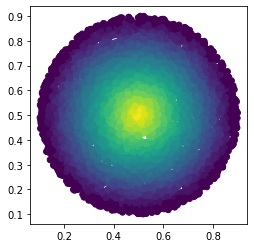

In [42]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(X[:,0], X[:,1], c=u)
ax.set_aspect('equal')
plt.show()